In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import cv2
import kornia
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt


In [9]:
# Define the Generator and Discriminator networks (DCGAN architecture)
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        self.rotation_head = nn.Linear(768, 4)
  


    def forward(self, z):
        img = self.model(z)
        rotation_pred = self.rotation_head(img.view(img.size(0), 768))


        return img, rotation_pred

class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, img):
        return self.model(img)

    
    

In [10]:

# Hyperparameters
latent_dim = 100
img_channels = 3  # CIFAR-10 images are in RGB, so 3 channels
batch_size = 64
lr = 0.0002
epochs = 1
sample_interval = 100  # Interval to save generated samples

# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize networks and optimizers
generator = Generator(latent_dim, img_channels).to(device)
discriminator = Discriminator(img_channels).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

# Data loading (CIFAR-10 dataset)
# transform = transforms.Compose([
#     transforms.Resize(64),           # Resize images to a larger size (optional)
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=3),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10, interpolation=3, fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjust these values based on your dataset's specific RGB mean and std
])



In [11]:
dataloader = DataLoader(
    datasets.CIFAR10('data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)


Files already downloaded and verified


[Epoch 0/1] [Batch 0/782] [D loss: 1.459429383277893] [G loss: 1.4325535297393799] [Rotation loss: 1.3881957530975342]
[Epoch 0/1] [Batch 100/782] [D loss: 0.01420906838029623] [G loss: 6.420710563659668] [Rotation loss: 1.3746812343597412]
[Epoch 0/1] [Batch 200/782] [D loss: 0.006110957823693752] [G loss: 6.5480499267578125] [Rotation loss: 1.3898295164108276]
[Epoch 0/1] [Batch 300/782] [D loss: 0.007341921329498291] [G loss: 6.426769256591797] [Rotation loss: 1.3736565113067627]
[Epoch 0/1] [Batch 400/782] [D loss: 0.007850077003240585] [G loss: 6.4448933601379395] [Rotation loss: 1.3979365825653076]
[Epoch 0/1] [Batch 500/782] [D loss: 0.006448269356042147] [G loss: 6.39151668548584] [Rotation loss: 1.3852274417877197]
[Epoch 0/1] [Batch 600/782] [D loss: 0.005439065396785736] [G loss: 7.560410022735596] [Rotation loss: 1.3984684944152832]
[Epoch 0/1] [Batch 700/782] [D loss: 0.009038953110575676] [G loss: 6.615503787994385] [Rotation loss: 1.4002058506011963]


NameError: name 'vutils' is not defined

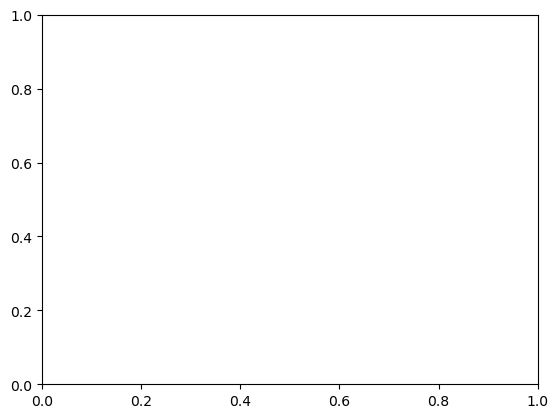

In [12]:
# Create lists to store losses
d_losses = []
g_losses = []
rotation_losses = [] 
ssim_values = []


# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        batch_size = imgs.size(0)

        # Random rotations for self-supervised task
        angle_classes = torch.randint(0, 4, (batch_size,)).to(device)
        angles = angle_classes.float() * 90.0 * (np.pi/180.0)  # Convert to radians
        rotated_imgs = kornia.geometry.rotate(imgs, angles)

        # Train Discriminator on rotated real images
        optimizer_D.zero_grad()
        real_outputs = discriminator(rotated_imgs)
        real_labels = torch.ones_like(real_outputs)
        real_loss = criterion(real_outputs, real_labels)

        noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images, _ = generator(noise)
        fake_outputs = discriminator(fake_images.detach())
        fake_labels = torch.zeros_like(fake_outputs)
        fake_loss = criterion(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator on fake images and rotation prediction
        optimizer_G.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, torch.ones_like(fake_outputs))

        _, rotation_preds = generator(noise)
        rot_loss = nn.CrossEntropyLoss()(rotation_preds, angle_classes)

        total_g_loss = g_loss + rot_loss
        total_g_loss.backward()
        optimizer_G.step()

        # Print progress
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}] [Rotation loss: {rot_loss.item()}]")
        
        # Append losses
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        rotation_losses.append(rot_loss.item())

    # Save generated images at specified intervals
    if epoch % sample_interval == 0:
        with torch.no_grad():
            noise = torch.randn(25, latent_dim, 1, 1).to(device)
            generated_images, _ = generator(noise)
            generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]

        # Plot the generated images
        fig, ax = plt.subplots()
        ax.imshow(np.transpose(vutils.make_grid(generated_images.cpu(), padding=2, normalize=True), (1,2,0)))
        plt.show()
            
   

In [15]:

# # Save the generator and discriminator models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


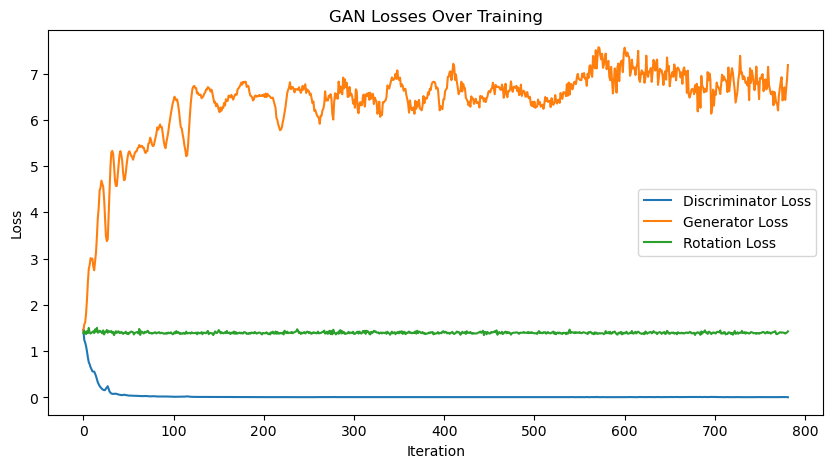

In [13]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.plot(rotation_losses, label="Rotation Loss")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("GAN Losses Over Training")
plt.show()



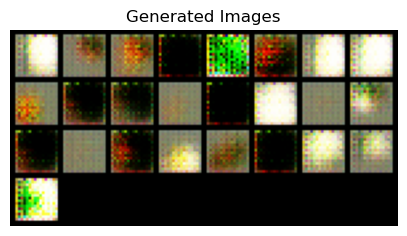

In [16]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Load the saved generator model
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()

# Generate a batch of fake images
with torch.no_grad():
    noise = torch.randn(25, latent_dim, 1, 1)
    generated_images, _ = generator(noise)

    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]


# Display the generated images in a grid
fig = plt.figure(figsize=(5, 5))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()


In [17]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from lpips import LPIPS

# Load the saved generator model
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()

# Create a DataLoader for real images
real_transform = transforms.Compose([
    transforms.Resize(256),  # Resize images to a larger size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

real_dataset = datasets.CIFAR10('data', train=True, download=True, transform=real_transform)
real_dataloader = DataLoader(real_dataset, batch_size=64, shuffle=True)

# Initialize LPIPS metric
lpips_metric = LPIPS(net='alex', spatial=True)  # Use 'spatial' for spatial LPIPS

# Calculate LPIPS for generated images
lpips_score = 0.0
num_batches = 0

with torch.no_grad():
    for i, (real_images, _) in enumerate(real_dataloader):
        # Generate fake images
        batch_size = real_images.size(0)
        noise = torch.randn(batch_size, latent_dim, 1, 1)
        generated_images, _ = generator(noise)

        generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]

        # Resize generated images to match the larger size
        generated_images_resized = torch.nn.functional.interpolate(generated_images, size=(256, 256), mode='bilinear', align_corners=False)

        # Calculate LPIPS score for the batch
        lpips_batch = lpips_metric(real_images, generated_images_resized)
        lpips_score += lpips_batch.mean().item()
        num_batches += 1

# Calculate the average LPIPS score
average_lpips_score = lpips_score / num_batches
print(f"Average LPIPS Score: {average_lpips_score}")


Files already downloaded and verified
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [on]


/Users/sadianasrintisha/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sadianasrintisha/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/sadianasrintisha/anaconda3/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
Average LPIPS Score: 0.7640745196196125
